# Q-learning & explore

$$
Q(s_t, a_t) = Q(s_t, a_t) + \alpha \bigg[r_{t+1} +\gamma \max_a Q(s_{t+1}, a) - Q(s_t, a_t)\bigg]
$$

Q学习是off-policy, 比较激进的算法, 收敛慢, 但是收敛值高

加载需要的包

In [1]:
import numpy as np
import pandas as pd
import gymnasium as gym
from gym import register
import torch
import os
import random
from tqdm import tqdm
import d2l.torch as d2l
from collections import defaultdict
from rich.console import Console
cs = Console() # 可以把输出美化

### 定义算法

In [2]:
class Qlearning(object):
    def __init__(self, config):
        self.explore_type = config.explore_type
        self.n_actions = config.n_actions
        self.lr = config.lr
        self.gamma = config.gamma
        self.epsilon = config.epsilon_start
        self.sample_cnt = 0
        self.epsilon_start = config.epsilon_start
        self.epsilon_end = config.epsilon_end
        self.epsilon_decay =  config.epsilon_decay
        self.epsilon_decay_flag = config.epsilon_decay_flag
        self.Q_table = np.zeros((config.n_states, self.n_actions)) # 实际上每一个staste的action个数都是不一样的, 这个地方不准确
        self.__ucb_init()
    
    def __ucb_init(self):
        self.ucb_sa_visit_cnt_arr = np.array([])
        self.ucb_cnt = 0
        self.ucb_sa_visit_cnt_arr = np.ones(self.Q_table.shape) # (s,a)
    
    @staticmethod
    def explore_type_space():
        return {'epsilon_greedy', 'boltzmann', 'ucb', 'special_ucb', 'softmax', 'thompson'}
    
    def __softmax(self, actions_v):
        Exp = np.exp(actions_v + 1e-3) # 小小的优化
        return Exp / np.sum(Exp, axis=0)
    
    def __softmax_policy_init(self):
        self.Q_table = np.random.random(self.Q_table.shape)
    
    def _e_greedy(self, state):
        self.epsilon = self.epsilon_end
        if self.epsilon_decay_flag:
            self.epsilon = self.epsilon_end + (self.epsilon_start - self.epsilon_end) * np.exp(-self.sample_cnt / self.epsilon_decay) # 选择指数递减
        if np.random.uniform(0, 1) < self.epsilon or sum(self.Q_table[state]) == 0:
            # 选择随机动作, 使用sum函数有点吃时间复杂度, 删掉问题不大 (自我感觉), 或者初始化为极小值也行
            # return np.random.randint(len(self.Q_table[state])) # number of actions in state
            return np.random.randint(self.n_actions) # 因为 actions个数都是一样的, 所以这个地方就不用上面的那种方法了
        return np.argmax(self.Q_table[state])

    def _sp_ucb_policy(self, s): # special_ucb 再前期用 epsilon-greedy进行一个优化
        self.ucb_cnt += 1 # 迭代的轮数
        # 当使用过 nS种 action之前(使用同一种 action, 不用 state视为不同)使用 epsilon-greedy算法 (个人觉得不合理, 跑一次所有的 action不就已经有 nS 次了吗)
        not_state_once = np.sum(self.ucb_sa_visit_cnt_arr > 1, axis=1).sum() < self.ucb_sa_visit_cnt_arr.shape[0] # 先验动作
        if not_state_once:
            a_final = self._e_greedy(s)
            self.ucb_sa_visit_cnt_arr[s, a_final] += 1 # 用来记录在每个状态下选择每个行动的次数
            return a_final
        # softmax 可以使 sum=1 并且保持之前的大小关系, 这个地方相当于将两个部分分别进行了一个归一化
        b_t= self.__softmax(self.Q_table[s]) + self.__softmax(np.sqrt(2 * np.log(self.ucb_cnt) / self.ucb_sa_visit_cnt_arr[s]))
        a_final = np.argmax(b_t)
        self.ucb_sa_visit_cnt_arr[s, a_final] += 1
        return a_final
    
    def sample_action(self, state):
        self.sample_cnt += 1
        if self.explore_type == 'epsilon_greedy':
            return self._e_greedy(state)
        elif self.explore_type == 'boltzmann' or self.explore_type == 'softmax': # 属于 gradient bandit algorithm (sutton p37)
            if self.sample_cnt == 1 and self.explore_type == 'softmax': # 唯一不同就是有一个初始化
                self.__softmax_policy_init() # Q_table 为 (0,1)的随机数
            Ht = np.exp(self.Q_table[state] / self.epsilon)
            action_probs = Ht / np.sum(Ht)
            return np.random.choice(self.n_actions, p=action_probs)
        elif self.explore_type == 'ucb':
            if self.sample_cnt < self.n_actions:
                return self.sample_cnt # 这样就把所有的动作都试了一遍
            else:
                return np.argmax(self.__softmax(self.Q_table[state]) + self.__softmax(self.epsilon * np.sqrt(np.log(self.sample_cnt) / self.sample_cnt))) # 注意这个地方分母不是 cntA
        elif self.explore_type == 'special_ucb':
            return self._sp_ucb_policy(state)
        elif self.explore_type == 'thompson':
            alpha = self.__softmax(self.Q_table[state]) # 根据q值确定, q越大选择的概率越大, 在这里就是 alpha越大
            return np.argmax(np.random.beta(alpha, 1 - alpha))
        else:
            raise ValueError

    def predict_action(self, state):
        if self.explore_type in ['epsilon_greedy', 'ucb', 'special_ucb']:
            return np.argmax(self.Q_table[state]) # predict 的时候一直 exploitation
        elif self.explore_type == 'boltzmann' or self.explore_type == 'softmax':
            Ht = np.exp(self.Q_table[state] / self.epsilon)
            action_probs = Ht / np.sum(Ht)
            return np.random.choice(self.n_actions, p=action_probs)
        elif self.explore_type == 'thompson':
            alpha = self.__softmax(self.Q_table[state]) # 根据q值确定, q越大选择的概率越大, 在这里就是 alpha越大
            return np.argmax(np.random.beta(alpha, 1 - alpha))
    
    def update(self, state, action, reward, next_state, terminated):
        Q_predict = self.Q_table[state][action] # 使用探索策略探索的动作
        Q_target = reward if terminated else (reward + self.gamma * np.max(self.Q_table[next_state])) # 贪心的选最好的
        self.Q_table[state][action] += self.lr * (Q_target - Q_predict) # 采用的是固定学习率的方法

设置随机数种子, 设置随机数种子可能会影响一定的性能, 因为禁用了 cuDNN

In [3]:
def SetSeed(env, seed):
    env.seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.backends.cudnn.deterministic = True # 设置 cuDNN 为确定性模式
    torch.backends.cudnn.benchmark = False # 禁用 cuDNN 的自动调优, 自动调优会根据 GPU特性进行优化, 可能导致结果不一样
    torch.backends.cudnn.enabled = False # 禁用 cuDNN

### 定义训练

In [4]:
def train(config, env, agent, mode='train'): # mode == 'test' 就是测试
    out_dict = {'algorithm': config.algorithm, 'explore_type': config.explore_type}
    print(f'环境 : {config.env_name}, 算法 : {config.algorithm}, 设备 : {config.device}')
    rewards = []
    steps =[]
    epochs = config.train_epochs if mode == 'train' else config.test_epochs
    tq_iterator = tqdm(range(epochs)) # 使用 tqdm可以创建一个进度条
    for i_ep in tq_iterator:
        tq_iterator.set_description(f'{mode}[ {i_ep + 1}/{epochs} ] (Epsilon: {agent.epsilon:.3f})')
        ep_reward = 0
        ep_step = 0
        state = env.reset()[0] # new api 返回的是 (state, info)
        while True:
            ep_step += 1
            action = agent.sample_action(state) if mode == 'train' else agent.predict_action(state)
            next_state, reward, terminated, truncated, info = env.step(action)
            agent.update(state, action, reward, next_state, terminated)
            state = next_state
            ep_reward += reward
            if terminated or truncated or ep_step > config.max_step:
                break
        rewards.append(ep_reward)
        steps.append(ep_step)
        last_10_mean = np.mean(rewards[-10:])
        tq_iterator.set_postfix(reward = f'{last_10_mean:.3f}')
        tq_iterator.update()
    out_dict['rewards'] = rewards
    out_dict['steps'] = steps
    out_dict['meanReward'] = np.mean(rewards)
    out_dict['meanSteps'] = np.mean(steps)
    return out_dict


### 定义环境

In [5]:
register(id='FrozenLakeEasy-v0', entry_point='gym.envs.toy_text:FrozenLakeEnv', kwargs={'is_slippery':False})
FrozenLake = gym.make('GymV26Environment-v0', env_id='FrozenLakeEasy-v0')
class CliffWalkingWrapper(gym.Wrapper):
    def __init__(self, env):
        gym.Wrapper.__init__(self, env)
        self.nrow = 4
        self.ncol = 12
        self.desc = np.array([ # 可视化
            [b'F', b'F', b'F', b'F', b'F', b'F', b'F', b'F', b'F', b'F', b'F', b'F'],
            [b'F', b'F', b'F', b'F', b'F', b'F', b'F', b'F', b'F', b'F', b'F', b'F'],
            [b'F', b'F', b'F', b'F', b'F', b'F', b'F', b'F', b'F', b'F', b'F', b'F'],
            [b'S', b'X', b'X', b'X', b'X', b'X', b'X', b'X', b'X', b'X', b'X', b'G'],
        ])
    def step(self, action): # 为了能在可视化的时候可以用
        actionMap = {0:3, 1:2, 2:1, 3:0} # 应该没有问题
        action = actionMap[action]
        return self.env.step(action)

CliffWalking = gym.make('CliffWalking-v0')
CliffWalking = CliffWalkingWrapper(CliffWalking)
env_dict = {
    'FrozenLakeEasy-v0': FrozenLake,
    'CliffWalking-v0': CliffWalking
}

### 设置参数

In [6]:
class Configuration:
    def __init__(self, env_name, nS, nA, explore_type='epsilon_greedy'):
        self.env_name = env_name
        self.algorithm = 'Q-Learning'
        self.explore_type = explore_type
        self.train_epochs = 400
        self.test_epochs = 20
        self.max_steps = 200
        self.epsilon_start = 0.65
        self.epsilon_end = 0.005
        self.epsilon_decay = 100
        self.epsilon_decay_flag =True
        self.max_step = 500
        self.gamma = 0.9
        self.lr = 0.1
        self.n_states = nS
        self.n_actions = nA
        self.device = torch.device(d2l.try_gpu())
    def __str__(self): # 打印的时候调用这个函数
        return f'Config : (Env={self.env_name}, algorithm={self.algorithm}, exploreType={self.explore_type} (gamma={self.gamma}, learning_rate={self.lr}))'
result = [] # 保存各个环境的最终结果

### 可视化工具

直接搬过来用了, 有点不太好用, 需要用到的时候再重写

In [7]:
import matplotlib.pyplot as plt
from enum import Enum
import seaborn as sns

class Direct(Enum):
    Left_v = 0
    Down_v = 1
    Right_v = 2
    Up_v = 3
    Left = -1
    Down = -1
    Right = +1
    Up = +1
    Left_s = r'$\Leftarrow$'
    Down_s = r'$\Downarrow$'
    Right_s = r'$\Rightarrow$'
    Up_s = r'$\Uparrow$'


class QTablePlot:
    def __init__(self, Q_table, env):
        self.Q_table = Q_table
        self.env = env
        self.env_rows, self.env_cols = env.nrow, env.ncol
        self.table = np.zeros((self.env_rows * 3, self.env_cols * 3))
        self.direct = Direct
        self.text_record_dict = {}
        self.record_SHG = {}

    def _fill_table(self, q_table: np.ndarray):
        text_str_list = [
            Direct.Left_s.value, 
            Direct.Down_s.value, 
            Direct.Right_s.value, 
            Direct.Up_s.value
        ]
        env_desc_str = ''.join(''.join(i) for i in self.env.desc.astype(str))
        for r in range(self.env_rows):
            for c in range(self.env_cols):
                s = r * self.env_cols + c
                center_r = 1 + (self.env_rows - r - 1) * 3
                # center_r = 1 + r * 3
                center_c = 1 + c * 3
                # "Left","Down","Right","Up"
                self.table[
                    center_r , center_c + Direct.Left.value
                ] = q_table[s, Direct.Left_v.value]
                self.table[
                    center_r , center_c + Direct.Right.value
                ] = q_table[s, Direct.Right_v.value]
                self.table[
                    center_r + Direct.Down.value , center_c
                ] = q_table[s, Direct.Down_v.value]
                self.table[
                    center_r + Direct.Up.value , center_c
                ] = q_table[s, Direct.Up_v.value]
                # center
                self.table[
                    center_r , center_c
                ] = q_table[s].mean()

                idx = np.argmax(q_table[s])
                name = text_str_list[idx]
                mv_v = Direct[Direct(idx).name[:-2]].value

                if idx in [0, 2]:
                    self.text_record_dict[f'{center_r},{center_c + mv_v}'] = name

                else:
                    self.text_record_dict[f'{center_r + mv_v},{center_c}'] = name
                
                if env_desc_str[s] != '.' and env_desc_str[s] != 'F':
                    self.record_SHG[f'{center_r},{center_c}'] = env_desc_str[s]
    
    @staticmethod
    def exp_smooth(data, weight=0.9):  
        '''用于指数平滑曲线
        '''
        last = data[0]  # First value in the plot (first timestep)
        smoothed = list()
        for point in data:
            smoothed_val = last * weight + (1 - weight) * point  # 计算平滑值
            smoothed.append(smoothed_val)                    
            last = smoothed_val                                
        return smoothed

    def exp_smooth_plot_rewards(self, rewards, title="", ax=None):
        sns.set()
        if ax:
            ax.set_title(f"{title}learning curve(expSmooth)")
            ax.set_xlim(0, len(rewards), 10)  # 设置x轴的范围
            ax.set_xlabel('epsiodes')
            ax.plot(rewards, label='rewards')
            ax.plot(self.exp_smooth(rewards), label='smoothed')
            ax.legend()
            return
        sns.set()
        plt.figure()  # 创建一个图形实例，方便同时多画几个图
        plt.title(f"{title}")
        plt.xlim(0, len(rewards), 10)  # 设置x轴的范围
        plt.xlabel('epsiodes')
        plt.plot(rewards, label='rewards')
        plt.plot(self.exp_smooth(rewards), label='smoothed')
        plt.legend()

    def rewards_plot(self, rewards, window_size=10, freq=1, title='', axes=None):
        record_arr = np.array(rewards)
        record_smooth = []
        std_list = []
        if len(record_arr) < window_size:
            window_size = 10
        for i in range(1, len(rewards), freq):
            tmp_arr = record_arr[max(0, i-window_size):i]
            record_smooth.append(np.mean(tmp_arr))
            std_list.append(np.std(tmp_arr))
        
        if axes is None:
            fig, axes = plt.subplots(1, 2, figsize=(16, 4))

        self.exp_smooth_plot_rewards(rewards, title, ax=axes[0])        
        axes[1].set_title(f'{title}Learning Rewards Trend')
        axes[1].plot(record_smooth, label=f'Rewards for each {window_size} episode.')
        axes[1].fill_between(
            x=np.arange(len(record_smooth)),
            y1=np.array(record_smooth) - np.array(std_list), 
            y2=np.array(record_smooth) + np.array(std_list), 
            color='green', alpha=0.1
            )
        plt.legend()
        plt.show()

    def Qtable_plot(self, title=''):
        self._fill_table(self.Q_table)
        plt.title(f'{title}Agent Qtable')
        plt.imshow(
            self.table,
            cmap="RdBu_r", 
            interpolation="bilinear",
            vmin=-np.abs(self.table).max() , 
            vmax=np.abs(self.table).max()
        )
        plt.xlim(-0.5, 3 * self.env_cols - 0.5)
        plt.ylim(-0.5, 3 * self.env_rows - 0.5)
        plt.xticks(np.arange(-0.5, 3 * self.env_cols, 3), range(self.env_cols + 1))
        plt.yticks(np.arange(-0.5, 3 * self.env_rows, 3), range(self.env_rows + 1))
        plt.grid(True)
        for k, v in self.text_record_dict.items():
            y_, x_ = k.split(',')
            plt.text(int(x_), int(y_), f'{v}', va='center', ha='center')
        
        for k, v in self.record_SHG.items():
            y_, x_ = k.split(',')
            plt.text(int(x_), int(y_), f'{v}', va='center', ha='center', color='darkred', fontdict={'weight': 'bold'})
        plt.show()


### 使用5种探索策略

In [8]:
cs.print(Qlearning.explore_type_space())

{'special_ucb', 'epsilon_greedy', 'ucb', 'thompson', 'boltzmann', 'softmax'}

`defaultdict` 是 `collections` 里面的一个函数, 可以很方便的构建一个 `dict`, 当访问没有创建过的索引的时候就会创建一个 `list`

In [9]:
summary_dict = defaultdict(list)

In [10]:
def display(env, config):
    print('---' * 45)
    print(f'EnvName = {config.env_name}')
    print(f'状态数: {config.n_states}, 动作数: {config.n_actions}')
    cs.print(config)

def config_init(env, env_name, explore_type):
    return Configuration(env_name, env.observation_space.n, env.action_space.n, explore_type)

def MakeSummary(train_result, test_result, name):
    summary_dict['envName'].append(name)
    summary_dict['algorithm'].append(train_result['algorithm'])
    summary_dict['exploreType'].append(train_result['explore_type'])
    summary_dict['meanReward'].append(test_result['meanReward'])
    summary_dict['meanSteps'].append(test_result['meanSteps'])

def IterAllEnv(explore_type):
    for env_name, env in env_dict.items():
        config = config_init(env, env_name, explore_type)
        display(env, config)
        agent = Qlearning(config)
        train_result = train(config, env, agent)
        test_result = train(config, env, agent, mode='test')
        MakeSummary(train_result, test_result, env_name)
        PLOTER = QTablePlot(agent.Q_table, env)
        PLOTER.rewards_plot(train_result['rewards'], title=f'exploreType: {config.explore_type} | ')
        PLOTER.Qtable_plot(f'exploreType: {config.explore_type} | ')
        

#### softmax 策略

---------------------------------------------------------------------------------------------------------------------------------------
EnvName = FrozenLakeEasy-v0
状态数: 16, 动作数: 4


Config : (Env=FrozenLakeEasy-v0, algorithm=Q-Learning, exploreType=softmax (gamma=0.9, learning_rate=0.1))

环境 : FrozenLakeEasy-v0, 算法 : Q-Learning, 设备 : cuda:0


Test[ 400/400 ] (Epsilon: 0.650): 100%|██████████| 400/400 [00:00<00:00, 662.09it/s, reward=0.200] 


环境 : FrozenLakeEasy-v0, 算法 : Q-Learning, 设备 : cuda:0


Test[ 20/20 ] (Epsilon: 0.650): 100%|██████████| 20/20 [00:00<00:00, 743.09it/s, reward=0.100]


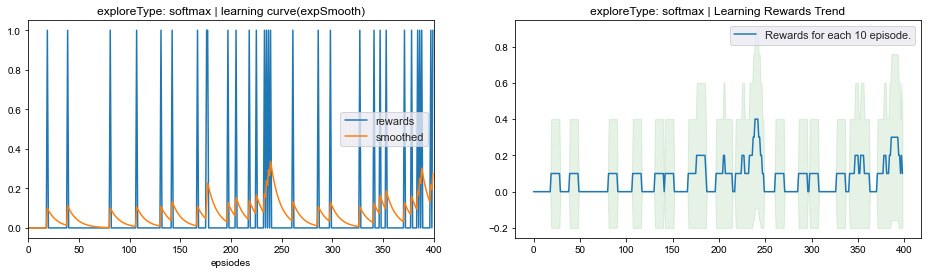

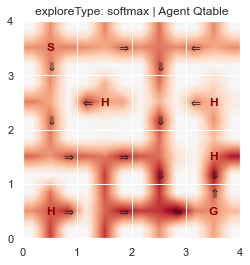

---------------------------------------------------------------------------------------------------------------------------------------
EnvName = CliffWalking-v0
状态数: 48, 动作数: 4


Config : (Env=CliffWalking-v0, algorithm=Q-Learning, exploreType=softmax (gamma=0.9, learning_rate=0.1))

环境 : CliffWalking-v0, 算法 : Q-Learning, 设备 : cuda:0


Test[ 400/400 ] (Epsilon: 0.650): 100%|██████████| 400/400 [00:01<00:00, 257.93it/s, reward=-37.400]


环境 : CliffWalking-v0, 算法 : Q-Learning, 设备 : cuda:0


Test[ 20/20 ] (Epsilon: 0.650): 100%|██████████| 20/20 [00:00<00:00, 456.07it/s, reward=-31.700]


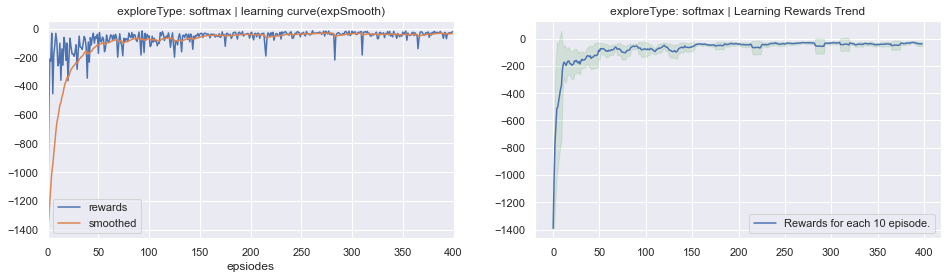

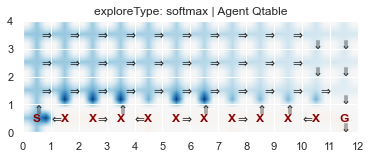

In [11]:
IterAllEnv('softmax')

---------------------------------------------------------------------------------------------------------------------------------------
EnvName = FrozenLakeEasy-v0
状态数: 16, 动作数: 4


Config : (Env=FrozenLakeEasy-v0, algorithm=Q-Learning, exploreType=ucb (gamma=0.9, learning_rate=0.1))

环境 : FrozenLakeEasy-v0, 算法 : Q-Learning, 设备 : cuda:0


Test[ 400/400 ] (Epsilon: 0.650): 100%|██████████| 400/400 [00:07<00:00, 54.81it/s, reward=0.000]


环境 : FrozenLakeEasy-v0, 算法 : Q-Learning, 设备 : cuda:0


Test[ 20/20 ] (Epsilon: 0.650): 100%|██████████| 20/20 [00:00<00:00, 107.87it/s, reward=0.000]


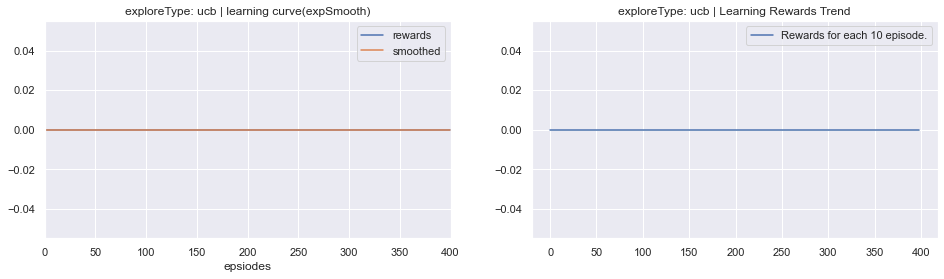

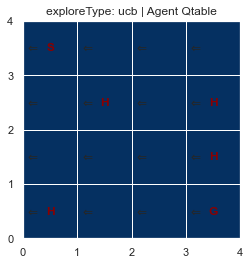

---------------------------------------------------------------------------------------------------------------------------------------
EnvName = CliffWalking-v0
状态数: 48, 动作数: 4


Config : (Env=CliffWalking-v0, algorithm=Q-Learning, exploreType=ucb (gamma=0.9, learning_rate=0.1))

环境 : CliffWalking-v0, 算法 : Q-Learning, 设备 : cuda:0


Test[ 400/400 ] (Epsilon: 0.650): 100%|██████████| 400/400 [00:00<00:00, 453.20it/s, reward=-13.000]


环境 : CliffWalking-v0, 算法 : Q-Learning, 设备 : cuda:0


Test[ 20/20 ] (Epsilon: 0.650): 100%|██████████| 20/20 [00:00<00:00, 978.38it/s, reward=-13.000] 


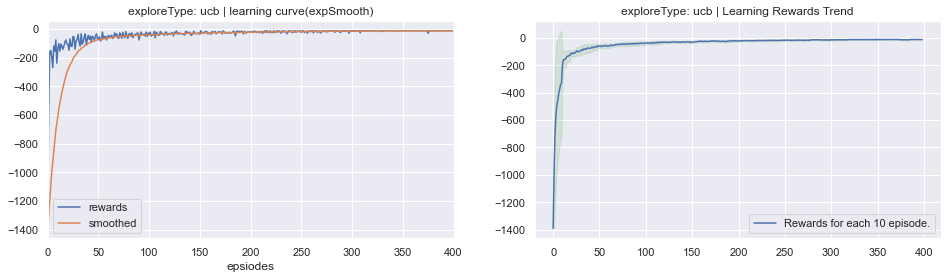

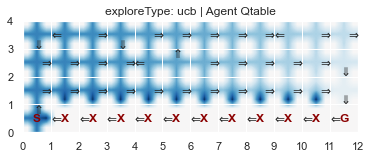

In [12]:
IterAllEnv('ucb')

#### special ucb 策略

---------------------------------------------------------------------------------------------------------------------------------------
EnvName = FrozenLakeEasy-v0
状态数: 16, 动作数: 4


Config : (Env=FrozenLakeEasy-v0, algorithm=Q-Learning, exploreType=special_ucb (gamma=0.9, learning_rate=0.1))

环境 : FrozenLakeEasy-v0, 算法 : Q-Learning, 设备 : cuda:0


Test[ 400/400 ] (Epsilon: 0.392): 100%|██████████| 400/400 [00:00<00:00, 803.24it/s, reward=1.000] 


环境 : FrozenLakeEasy-v0, 算法 : Q-Learning, 设备 : cuda:0


Test[ 20/20 ] (Epsilon: 0.392): 100%|██████████| 20/20 [00:00<00:00, 1028.31it/s, reward=1.000]


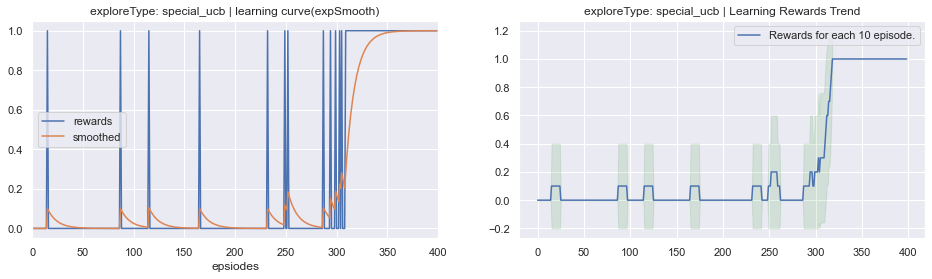

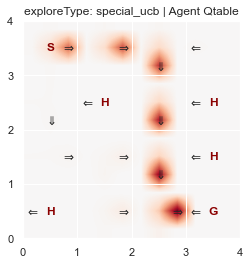

---------------------------------------------------------------------------------------------------------------------------------------
EnvName = CliffWalking-v0
状态数: 48, 动作数: 4


Config : (Env=CliffWalking-v0, algorithm=Q-Learning, exploreType=special_ucb (gamma=0.9, learning_rate=0.1))

环境 : CliffWalking-v0, 算法 : Q-Learning, 设备 : cuda:0


Test[ 400/400 ] (Epsilon: 0.247): 100%|██████████| 400/400 [00:01<00:00, 378.14it/s, reward=-13.000]


环境 : CliffWalking-v0, 算法 : Q-Learning, 设备 : cuda:0


Test[ 20/20 ] (Epsilon: 0.247): 100%|██████████| 20/20 [00:00<00:00, 729.61it/s, reward=-13.000]


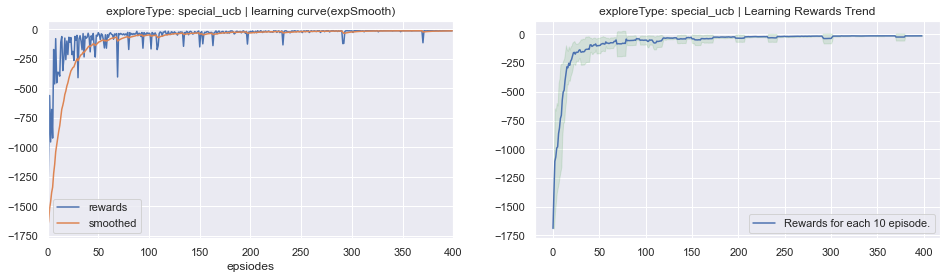

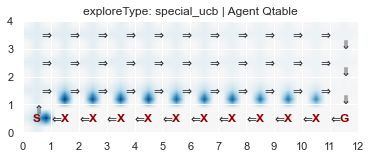

In [13]:
IterAllEnv('special_ucb')

#### $\epsilon-greedy$ 策略

---------------------------------------------------------------------------------------------------------------------------------------
EnvName = FrozenLakeEasy-v0
状态数: 16, 动作数: 4


Config : (Env=FrozenLakeEasy-v0, algorithm=Q-Learning, exploreType=epsilon_greedy (gamma=0.9, learning_rate=0.1))

环境 : FrozenLakeEasy-v0, 算法 : Q-Learning, 设备 : cuda:0


Test[ 400/400 ] (Epsilon: 0.005): 100%|██████████| 400/400 [00:00<00:00, 911.88it/s, reward=1.000] 


环境 : FrozenLakeEasy-v0, 算法 : Q-Learning, 设备 : cuda:0


Test[ 20/20 ] (Epsilon: 0.005): 100%|██████████| 20/20 [00:00<00:00, 1114.81it/s, reward=1.000]


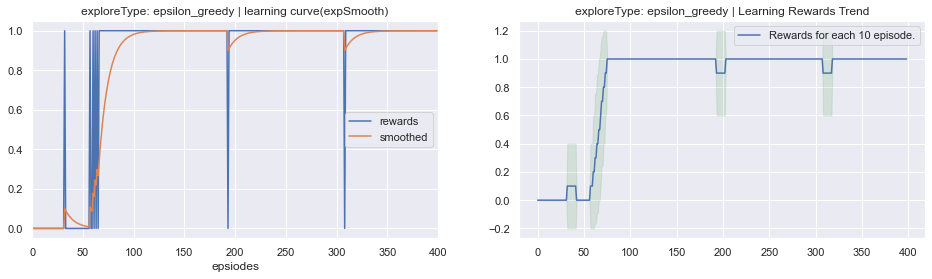

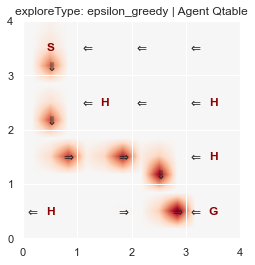

---------------------------------------------------------------------------------------------------------------------------------------
EnvName = CliffWalking-v0
状态数: 48, 动作数: 4


Config : (Env=CliffWalking-v0, algorithm=Q-Learning, exploreType=epsilon_greedy (gamma=0.9, learning_rate=0.1))

环境 : CliffWalking-v0, 算法 : Q-Learning, 设备 : cuda:0


Test[ 400/400 ] (Epsilon: 0.005): 100%|██████████| 400/400 [00:00<00:00, 475.08it/s, reward=-13.000]


环境 : CliffWalking-v0, 算法 : Q-Learning, 设备 : cuda:0


Test[ 20/20 ] (Epsilon: 0.005): 100%|██████████| 20/20 [00:00<00:00, 627.12it/s, reward=-13.000]


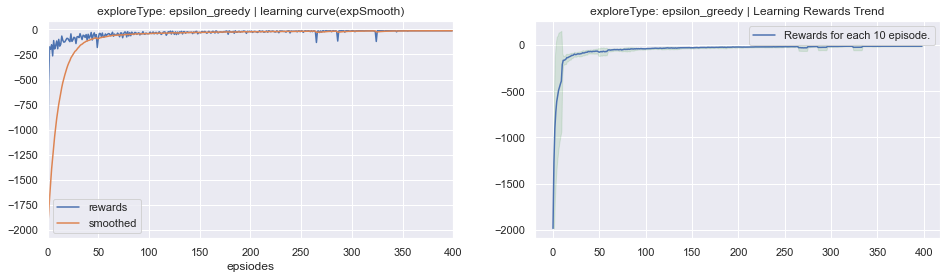

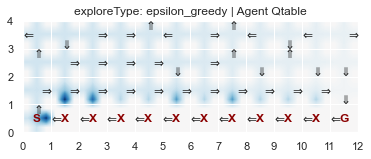

In [14]:
IterAllEnv('epsilon_greedy')

#### Thompson 策略

---------------------------------------------------------------------------------------------------------------------------------------
EnvName = FrozenLakeEasy-v0
状态数: 16, 动作数: 4


Config : (Env=FrozenLakeEasy-v0, algorithm=Q-Learning, exploreType=thompson (gamma=0.9, learning_rate=0.1))

环境 : FrozenLakeEasy-v0, 算法 : Q-Learning, 设备 : cuda:0


Test[ 400/400 ] (Epsilon: 0.650): 100%|██████████| 400/400 [00:00<00:00, 651.52it/s, reward=0.000] 


环境 : FrozenLakeEasy-v0, 算法 : Q-Learning, 设备 : cuda:0


Test[ 20/20 ] (Epsilon: 0.650): 100%|██████████| 20/20 [00:00<00:00, 590.20it/s, reward=0.100]


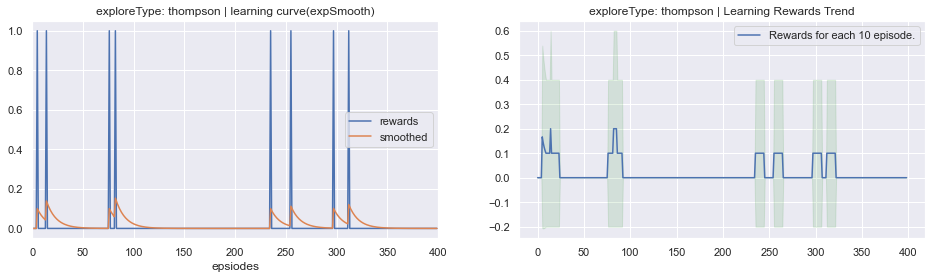

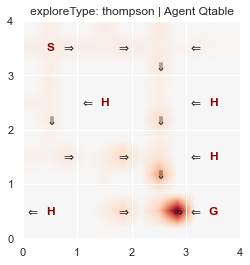

---------------------------------------------------------------------------------------------------------------------------------------
EnvName = CliffWalking-v0
状态数: 48, 动作数: 4


Config : (Env=CliffWalking-v0, algorithm=Q-Learning, exploreType=thompson (gamma=0.9, learning_rate=0.1))

环境 : CliffWalking-v0, 算法 : Q-Learning, 设备 : cuda:0


Test[ 400/400 ] (Epsilon: 0.650): 100%|██████████| 400/400 [00:01<00:00, 200.26it/s, reward=-34.800]


环境 : CliffWalking-v0, 算法 : Q-Learning, 设备 : cuda:0


Test[ 20/20 ] (Epsilon: 0.650): 100%|██████████| 20/20 [00:00<00:00, 272.95it/s, reward=-47.700]


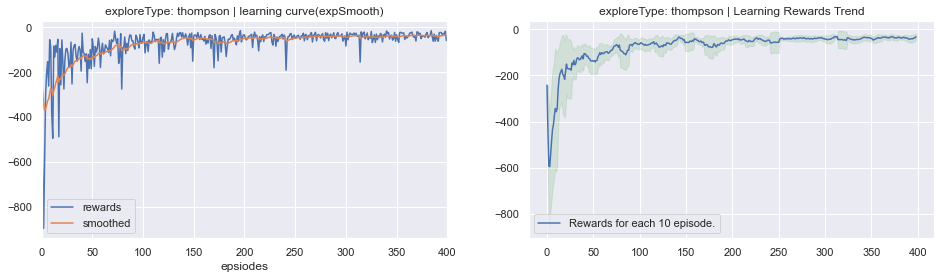

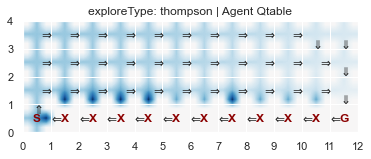

In [15]:
IterAllEnv('thompson')

#### boltzmann 策略

---------------------------------------------------------------------------------------------------------------------------------------
EnvName = FrozenLakeEasy-v0
状态数: 16, 动作数: 4


Config : (Env=FrozenLakeEasy-v0, algorithm=Q-Learning, exploreType=boltzmann (gamma=0.9, learning_rate=0.1))

环境 : FrozenLakeEasy-v0, 算法 : Q-Learning, 设备 : cuda:0


Test[ 400/400 ] (Epsilon: 0.650): 100%|██████████| 400/400 [00:00<00:00, 582.77it/s, reward=0.000] 


环境 : FrozenLakeEasy-v0, 算法 : Q-Learning, 设备 : cuda:0


Test[ 20/20 ] (Epsilon: 0.650): 100%|██████████| 20/20 [00:00<00:00, 590.12it/s, reward=0.100]


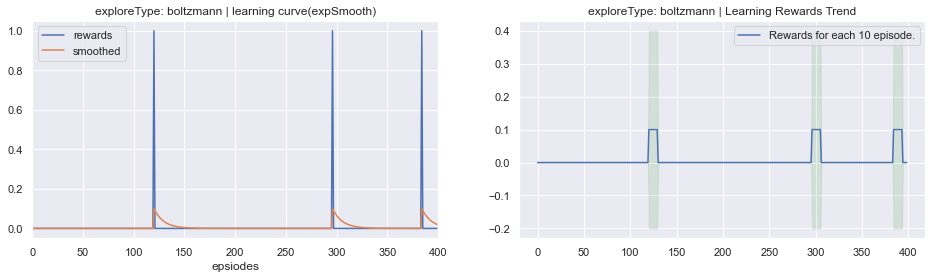

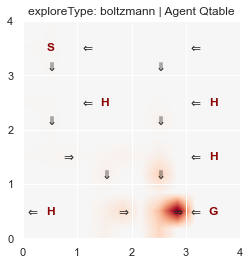

---------------------------------------------------------------------------------------------------------------------------------------
EnvName = CliffWalking-v0
状态数: 48, 动作数: 4


Config : (Env=CliffWalking-v0, algorithm=Q-Learning, exploreType=boltzmann (gamma=0.9, learning_rate=0.1))

环境 : CliffWalking-v0, 算法 : Q-Learning, 设备 : cuda:0


Test[ 400/400 ] (Epsilon: 0.650): 100%|██████████| 400/400 [00:02<00:00, 196.74it/s, reward=-32.600]


环境 : CliffWalking-v0, 算法 : Q-Learning, 设备 : cuda:0


Test[ 20/20 ] (Epsilon: 0.650): 100%|██████████| 20/20 [00:00<00:00, 218.11it/s, reward=-41.100]


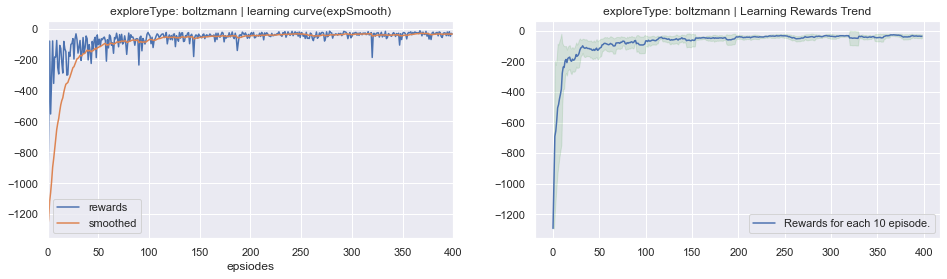

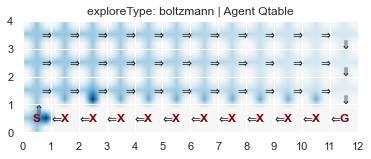

In [16]:
IterAllEnv('boltzmann')

In [17]:
pd.DataFrame(summary_dict).sort_values(by='exploreType')

,envName,algorithm,exploreType,meanReward,meanSteps
10,FrozenLakeEasy-v0,Q-Learning,boltzmann,0.10,6.35
11,CliffWalking-v0,Q-Learning,boltzmann,-41.90,41.90
6,FrozenLakeEasy-v0,Q-Learning,epsilon_greedy,1.00,6.00
7,CliffWalking-v0,Q-Learning,epsilon_greedy,-13.00,13.00
0,FrozenLakeEasy-v0,Q-Learning,softmax,0.05,11.60
1,CliffWalking-v0,Q-Learning,softmax,-34.00,34.00
4,FrozenLakeEasy-v0,Q-Learning,special_ucb,1.00,6.00
5,CliffWalking-v0,Q-Learning,special_ucb,-13.00,13.00
8,FrozenLakeEasy-v0,Q-Learning,thompson,0.05,8.20
9,CliffWalking-v0,Q-Learning,thompson,-42.00,42.00


In [18]:
pd.DataFrame(summary_dict).sort_values(by=['envName', 'meanReward'])

,envName,algorithm,exploreType,meanReward,meanSteps
9,CliffWalking-v0,Q-Learning,thompson,-42.00,42.00
11,CliffWalking-v0,Q-Learning,boltzmann,-41.90,41.90
1,CliffWalking-v0,Q-Learning,softmax,-34.00,34.00
3,CliffWalking-v0,Q-Learning,ucb,-13.00,13.00
5,CliffWalking-v0,Q-Learning,special_ucb,-13.00,13.00
7,CliffWalking-v0,Q-Learning,epsilon_greedy,-13.00,13.00
2,FrozenLakeEasy-v0,Q-Learning,ucb,0.00,501.00
0,FrozenLakeEasy-v0,Q-Learning,softmax,0.05,11.60
8,FrozenLakeEasy-v0,Q-Learning,thompson,0.05,8.20
10,FrozenLakeEasy-v0,Q-Learning,boltzmann,0.10,6.35
